<a href="https://colab.research.google.com/github/Rafaelalorenzini/ETL_Spotify/blob/main/ETL_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas



In [27]:
import sqlalchemy
import pandas as pd
from sqlalchemy.orm import sessionmaker
import requests
import json
from datetime import datetime
import datetime
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt


# E - Extract

Com uma conta do Spotify, é possível gerar um token que dará acesso às músicas que ouviu no tempo que escolher, para gerar basta ir no site: https://developer.spotify.com/console/get-recently-played/. O token expira em pouco tempo, o ideal seria automatizar a atualização.



In [42]:
DATABASE_LOCATION = "sqlite:///my_played_tracks.sqlite"
USER_ID = "rafaela.lorenzini"
TOKEN = "BQDtNpLfxDuTaPwHYFSpS_jdtMhTYMEl6kiIdOQPTa0GLDnn-J5JbmZ1BKAa7U_HfmfGif2KC931A07emR5E9ePpGOBAM1404Vvmf1-t6DWBiy9M_59qQoLMKPfomla547-6ubaIhS5qsZGvP_Z3PaTr95w45NhxW67FQxKj96yCxbpNsvybG_2DP8pVVu8KllTdaivnaQYXGOq8xXMCc1uLoCzsTG_wFR8UMX7C78O_epP81TyfEVToWrjJMqIWTnm75L6RFlT-CVROKSP3x_F_R6jI92Py6w"

In [43]:
def check_valid_data(df: pd.DataFrame) -> bool:
    # Checa se o dataframe está vazio
    if df.empty:
        print("Nenhuma música encontrada. Finalizando execução.")
        return False

    # Checa Primary Key
    if pd.Series(df["played_at"]).is_unique:
        pass
    else:
        raise Exception("Chave Primária repetida")

    # Checa por nulls
    if df.isnull().values.any():
        raise Exception("Valor Null encontrado ")

    return True


if __name__ == "__main__":

    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json",
        "Authorization": "Bearer {token}".format(token=TOKEN)
    }

    # Converte tempo em milisegundos
    today = datetime.datetime.now()
    week = today - datetime.timedelta(days=7)
    week_unix_timestamp = int(week.timestamp()) * 1000

    # Baixa dados das musicas que você escutou nas ultímas 24 horas
    r = requests.get("https://api.spotify.com/v1/me/player/recently-played?after={time}"
                     .format(time=week_unix_timestamp), headers=headers)

    data = r.json()


"""

T - Transform

Após extrais os dados diretamente da API do Spotify no tempo que escolhi (uma semana), os dados são TRANSFORMADOS para uma arquivo JSON.  
Este é um bom caminho, pois posso escolher as informações que desejo colocar em um dicionário e depois transformar em um DataFrame do Pandas. 

"""



    song_names = []
    artist_names = []
    played_at_list = []
    timestamps = []

    # Extrai apenas os dados relevantes do objeto json.
    for song in data["items"]:
        song_names.append(song["track"]["name"])
        artist_names.append(song["track"]["album"]["artists"][0]["name"])
        played_at_list.append(song["played_at"])
        timestamps.append(song["played_at"][0:10])

    # Prepara o dicionário para se tornar um dataframe do pandas
    song_dict = {
        "song_name": song_names,
        "artist_name": artist_names,
        "played_at": played_at_list,
        "timestamp": timestamps
    }

    song_df = pd.DataFrame(song_dict, columns=["song_name", "artist_name", "played_at", "timestamp"])

"""
A validação é uma etapa importante para visualizar se alguma música foi encontrada, se a chave primária está repetida ou se há algum valor null.
"""

    # Validação
    if check_valid_data(song_df):
        print("Dados validos")

"""
L - load

Utilizando o SQLAlchemy crio um banco de dados, esse banco de dados é então alimentado com os dados do DataFrame.

"""


    # Carregar dados para banco de dados
    engine = sqlalchemy.create_engine(DATABASE_LOCATION)
    conn = sqlite3.connect('my_played_tracks.sqlite')
    cursor = conn.cursor()

    sql_query = """
    CREATE TABLE IF NOT EXISTS my_played_tracks(
        song_name VARCHAR(200),
        artist_name VARCHAR(200),
        played_at VARCHAR(200),
        timestamp VARCHAR(200),
        CONSTRAINT primary_key_constraint PRIMARY KEY (played_at)
    )
    """

    cursor.execute(sql_query)
    print("Banco de dados aberto com sucesso")

    try:
        song_df.to_sql("my_played_tracks", engine, index=False, if_exists='append')
    except:
        print("Dados já existem no banco de dados")

    conn.close()
    print("Banco de dados fechado")

Dados validos
Banco de dados aberto com sucesso
Dados já existem no banco de dados
Banco de dados fechado


In [44]:
song_df = song_df.sort_values('timestamp')
song_df

,song_name,artist_name,played_at,timestamp
19,Partilhar,Rubel,2021-06-20T14:45:46.873Z,2021-06-20
17,A Cor É Rosa,Silva,2021-06-20T14:53:23.021Z,2021-06-20
16,Bem Melhor,Lagum,2021-06-20T14:56:26.909Z,2021-06-20
15,Continuo a Te Esperar,Hotelo,2021-06-20T15:00:04.466Z,2021-06-20
14,Sobre o Tempo,Pato Fu,2021-06-20T15:03:32.375Z,2021-06-20
13,Felicidade,Seu Jorge,2021-06-20T15:16:40.093Z,2021-06-20
18,Me Deixa Legal,Maglore,2021-06-20T14:49:33.627Z,2021-06-20
12,Não Tema,Nina Becker,2021-06-22T15:13:45.834Z,2021-06-22
11,espatódea,ANAVITÓRIA,2021-06-22T15:16:28.407Z,2021-06-22
10,O Leãozinho - Ao Vivo,Caetano Veloso,2021-06-22T15:19:25.169Z,2021-06-22


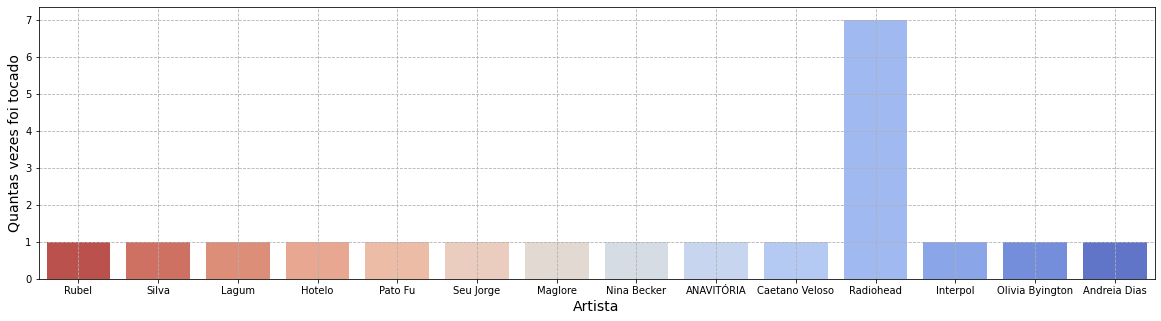

In [50]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="artist_name", data=song_df, palette='coolwarm_r')
ax.set_xlabel("Artista",fontsize=14)
ax.set_ylabel("Quantas vezes foi tocado",fontsize=14)
plt.grid(linestyle="--")
plt.show()